# 1. Klasyfikacja danych MIST przy użyciu K-neighbours

In [1]:
# Importuje standardowe biblioteki
import numpy as np
import os

# Aby wyniki uzyskiwane w tym notatniku były odtwarzalne
np.random.seed(42)

# Do rysowania ładnych wykresów
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Przygotowanie danych

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
#dzielenie danych na zbiór treningowy i testowy
X, y = mnist["data"], mnist["target"]
X_train, X_test, y_train, y_test = X[60000:], X[:60000], y[60000:], y[:60000]

# Klasyfikator

In [4]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [5]:
example = X[1] #0
knn_clf.predict([example])

array(['0'], dtype=object)

In [6]:
from sklearn.model_selection import cross_val_predict, cross_val_score
cross_val_score(knn_clf,X_train, y_train, cv=3, scoring="accuracy")

array([0.91211758, 0.93789379, 0.9579958 ])

In [7]:
from sklearn.model_selection import GridSearchCV

#bez sensownego procesora lepiej nie zalaczac
knn_for_test = KNeighborsClassifier()
clf = GridSearchCV(knn_for_test, {
    'weights' : ['distance', 'uniform'],
    'n_neighbors' : [2,3,4],
    'p' : [2.2,2.3,2.4]
}, cv = 2, verbose = 3)

clf.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] n_neighbors=3, p=2.3, weights=distance ..........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_neighbors=3, p=2.3, weights=distance, score=0.887, total= 5.3min
[CV] n_neighbors=3, p=2.3, weights=distance ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min remaining:    0.0s


[CV]  n_neighbors=3, p=2.3, weights=distance, score=0.944, total= 5.3min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 10.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 10.6min finished


GridSearchCV(cv=2, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3], 'p': [2.3],
                         'weights': ['distance']},
             verbose=3)

In [28]:
clf.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [29]:
clf.best_score_

0.9492

# 2. To samo, ale po dogenerowaniu danych

In [5]:
from scipy.ndimage.interpolation import shift
from sklearn.neighbors import KNeighborsClassifier

In [6]:
def shift_image(image,dx,dy):
    image = image.reshape((28,28))
    shifted_image = shift(image, [dy,dx], cval = 0, mode="constant")
    return shifted_image.reshape(-1)

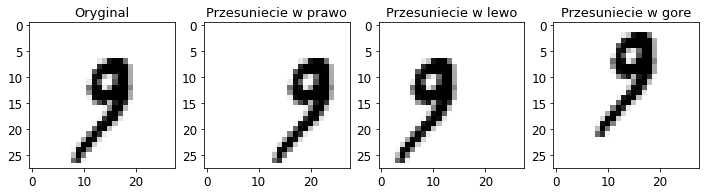

In [7]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

image = X_train[1000]
shifted_image_right = shift_image(image,5, 0)
shifted_image_up = shift_image(image, 0, -5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,6))
plt.subplot(141)
plt.title("Oryginal", fontsize=13)
plt.imshow(image.reshape(28,28), interpolation = "nearest", cmap = "Greys")

plt.subplot(142)
plt.title("Przesuniecie w prawo", fontsize=13)
plt.imshow(shifted_image_right.reshape(28,28),interpolation = "nearest", cmap="Greys")

plt.subplot(143)
plt.title("Przesuniecie w lewo", fontsize=13)
plt.imshow(shifted_image_left.reshape(28,28),interpolation = "nearest", cmap="Greys")


plt.subplot(144)
plt.title("Przesuniecie w gore", fontsize=13)
plt.imshow(shifted_image_up.reshape(28,28), interpolation = "nearest", cmap="Greys")
plt.show()

In [8]:
X_train_enriched = [image for image in X_train]
y_train_enriched = [label for label in y_train]

for dx, dy in ((3,0), (-3,0), (0,1), (0,-1)):
    for image, label in zip(X_train, y_train):
        X_train_enriched.append(shift_image(image,dx,dy))
        y_train_enriched.append(label)

X_train_enriched = np.array(X_train_enriched)
y_train_enriched = np.array(y_train_enriched)

In [9]:
shuffle_idx = np.random.permutation(len(X_train_enriched))
X_train_enriched = X_train_enriched[shuffle_idx]
y_train_enriched = y_train_enriched[shuffle_idx]

In [10]:
knn_clf = KNeighborsClassifier(weights = 'distance', n_neighbors = 4 )
#knn_clf = KNeighborsClassifier(**grid_search.best_params_) 

In [11]:
knn_clf.fit(X_train_enriched, y_train_enriched)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [ ]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)